# STRAWBERRY DETECTION USING TENSORFLOW (Object detection API and explored the GCP (Google Cloud Platform) by training, validating and testing the model on gcloud ML Engine

I used tensorflow's object detection API to train strawberry detector. It was fun building this detector, a quick run through of how I built it! 

1. Collect strawberry images :

I built my own dataset using a combination of images from a dataset and google.

I collected images in two ways - 
a. https://github.com/Horea94/Fruit-Images-Dataset - had images of strawberry in varying pose and angles (i took approximately 300) of these images
![Alt text](imgs/0_100.jpg?raw=true "Strawberry")

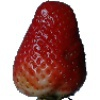

b. Handpicked images from Google Image search and downloaded them
![Alt text](imgs/S62.jpg?raw=true "Strawberry_Google")

![Alt text](imgs/S21.jpg?raw=true "Strawberry_Google_2")

2. Hand label images - 
Tensorflow requires the data to be in TRF format. To produce this we need, the object name, id, bounding boxes for the object (used during training and evaluation)

I used the tool LabelImg to label the images with strawberry and this tool automatically produces the xml files. Sample xmls files are also attached below:
![Alt text](imgs/LabelImg.PNG?raw=true "LabelImg")

![Alt text](imgs/LI2.PNG?raw=true "LI2")

![Alt text](imgs/LI3.PNG?raw=true "LI3")

![Alt text](imgs/annot.PNG?raw=true "annot")

Once the xml is generated, I ran a python script to create the TFRecord files (both for training data and test data).

I used the SSD Mobilenet model available in tensorflow. Link to the model - https://www.cs.unc.edu/~wliu/papers/ssd.pdf 
The mobilenet version is faster as it was created for the mobile applications, hence I chose this one. Discussion about the model, parameters and the configurations might become too long, hence cutting down all that information here. Another reason for choosing this model is because this model available in the object detection API has already been trained on the Coco dataset (more info about coco here - http://cocodataset.org/#home) and this dataset has not been trained on strawberries. Hence I thought it would be a good idea to start training the model with the trained ssd mobilenet model and this did seem to work well.

The next step is to create an object detection pipeline and I followed the steps available here - https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/configuring_jobs.md

It is important to create a label map for the dataset that has the labels and I created it like this :
![Alt text](imgs/labelmap.PNG?raw=true "labelmap")

Now with all the files I started training the model on google cloud. The reason for going with the cloud compute engine is because I dont have GPU in my laptop and it would be impossible to run the training locally. There is a procedure to set up the cloud account, create project and buckets for storing data. I did all of this and then trained the model.

The loss dropped to 1.0 pretty soon in about thousand iterations but it took a while for the loss to be stable (~0.5). 

![Alt text](imgs/Loss1.PNG?raw=true "Loss1")

![Alt text](imgs/Losszoomed.PNG?raw=true "Losszoomed")

Evaluation was done locally and I have shared some sample results here.

It was a good learning experience to try and build my own strawberry detector from scratch. Given the timeframe, I could not spend a lot of time in finetuning the model parameters and configurations. Some of the parameters I used default values while for others I tried to use the one that looked good from my knowledge. I would like to improve this model further and I will continue doing this when I find time.